# Predicción del valor de Bitcoin

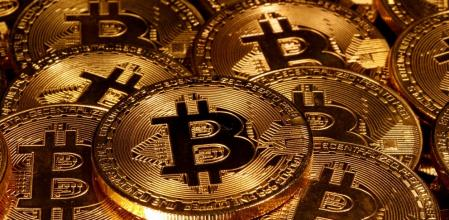

A partir del dataset `data/Binance_BTCUSDT_d.csv` implementa un modelo de series temporales para predecir el precio diario de cierre del Bitcoin en dólares

In [1]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import  ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('../../26_12_2023/ejercicios/data/Binance_BTCUSDT_d.csv',header=1,parse_dates=['date'])
data = data.sort_values('date')
print(data.shape)
data.head()

(1434, 10)


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
1433,1.502928e+09,2017-08-17,BTC/USDT,4469.93,4485.39,4200.74,4285.08,647.86,2812379.11,NaN
1432,1.503014e+09,2017-08-18,BTC/USDT,4285.08,4371.52,3938.77,4108.37,1178.07,4994493.56,NaN
1431,1.503101e+09,2017-08-19,BTC/USDT,4108.37,4184.69,3850.00,4139.98,371.15,1508239.39,NaN
1430,1.503187e+09,2017-08-20,BTC/USDT,4139.98,4211.08,4032.62,4086.29,463.54,1915636.35,NaN
1429,1.503274e+09,2017-08-21,BTC/USDT,4086.29,4119.62,3911.79,4016.00,685.12,2770592.06,NaN


In [3]:
data['date'] = pd.to_datetime(data['date'])

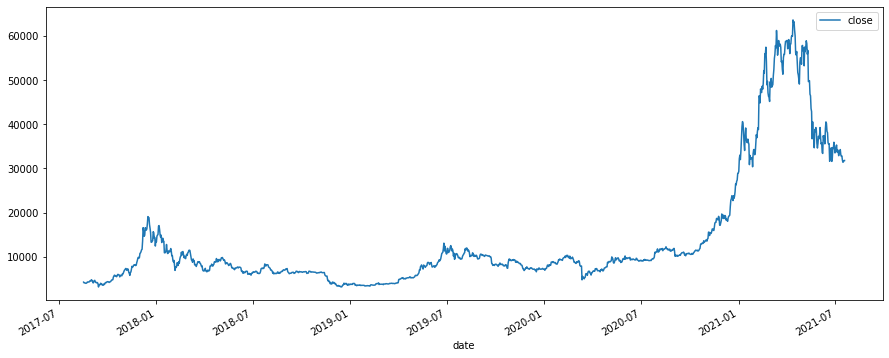

In [4]:
data[['date','close']].plot(x='date',y='close',figsize=(15,6));

## 1. Evalua la serie (autocorrelación, si es estacionaria o no, etc)

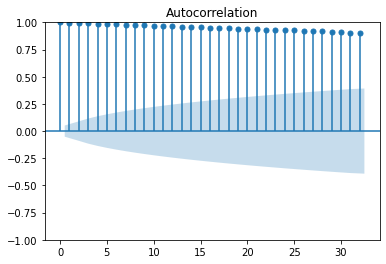

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['close']);

In [6]:
from statsmodels.tsa.stattools import adfuller
adfuller(data['close'])[1] #p-value

0.7880468376425953

In [7]:
adfuller(data['close'].diff().dropna())[1]

2.6266158594384764e-10

In [8]:
data['close_diff'] = data['close'].diff()
data

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount,close_diff
1433,1.502928e+09,2017-08-17,BTC/USDT,4469.93,4485.39,4200.74,4285.08,647.860000,2.812379e+06,NaN,NaN
1432,1.503014e+09,2017-08-18,BTC/USDT,4285.08,4371.52,3938.77,4108.37,1178.070000,4.994494e+06,NaN,-176.71
1431,1.503101e+09,2017-08-19,BTC/USDT,4108.37,4184.69,3850.00,4139.98,371.150000,1.508239e+06,NaN,31.61
1430,1.503187e+09,2017-08-20,BTC/USDT,4139.98,4211.08,4032.62,4086.29,463.540000,1.915636e+06,NaN,-53.69
1429,1.503274e+09,2017-08-21,BTC/USDT,4086.29,4119.62,3911.79,4016.00,685.120000,2.770592e+06,NaN,-70.29
...,...,...,...,...,...,...,...,...,...,...,...
4,1.626307e+12,2021-07-15,BTC/USDT,32820.03,33185.25,31133.00,31880.00,51639.576353,1.652078e+09,1099367.0,-940.02
3,1.626394e+12,2021-07-16,BTC/USDT,31874.49,32249.18,31020.00,31383.87,48499.864154,1.538343e+09,1067591.0,-496.13
2,1.626480e+12,2021-07-17,BTC/USDT,31383.86,31955.92,31164.31,31520.07,34012.242132,1.072816e+09,883442.0,136.20
1,1.626566e+12,2021-07-18,BTC/USDT,31520.07,32435.00,31108.97,31778.56,35923.716186,1.140964e+09,760979.0,258.49


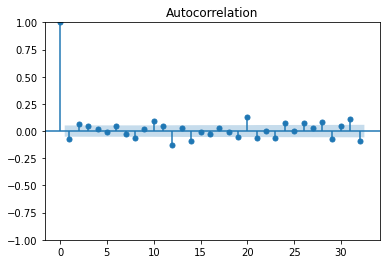

In [9]:
plot_acf(data['close_diff'].dropna());

## 2. Divide el conjunto de datos en train-test

In [10]:
X = data['close'].values
tp = int(1434*0.90) # me quedo con el 10% de los datos para test

train = X[:tp]
test = X[tp:]

In [11]:
len(train),len(test)

(1290, 144)

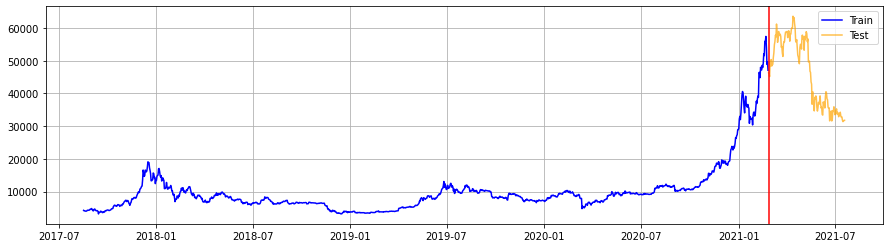

In [12]:
import matplotlib.pyplot as plt

index = data.date.values
plt.figure(figsize=(15,4))
plt.plot(index[0:tp],train,c='blue')
plt.plot(index[tp:],test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(index[tp], c="r")
plt.grid()

## 3. Construye y prueba diferentes modelos para predecir la serie temporal

# 1. ARIMA

In [13]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

p = range(2,5)
d = range(2,3)
q = range(2,5)

pdq = list(itertools.product(p,d,q))


In [14]:
results = []

for param in pdq:
    model_arima = ARIMA(train, order=param)
    model_arima_fit = model_arima.fit()
    results.append((param, model_arima_fit.aic))

C:\Users\botic\anaconda3\envs\ironhack\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [15]:
resultados_df = pd.DataFrame(results, columns=['ARIMA params','AIC']).sort_values('AIC')
resultados_df

,ARIMA params,AIC
2,"(2, 2, 4)",20151.347904
5,"(3, 2, 4)",20154.295067
4,"(3, 2, 3)",20154.760570
8,"(4, 2, 4)",20155.366744
7,"(4, 2, 3)",20155.520300
1,"(2, 2, 3)",20159.574458
6,"(4, 2, 2)",20170.677369
3,"(3, 2, 2)",20174.573560
0,"(2, 2, 2)",20179.914072


In [16]:
best_model = ARIMA(train, order=(2,2,4))
best_model_fit = best_model.fit()
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1290
Model:                 ARIMA(2, 2, 4)   Log Likelihood              -10068.674
Date:                Fri, 29 Dec 2023   AIC                          20151.348
Time:                        18:23:53   BIC                          20187.474
Sample:                             0   HQIC                         20164.909
                               - 1290                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2279      0.019    -65.439      0.000      -1.265      -1.191
ar.L2         -0.9803      0.017    -57.698      0.000      -1.014      -0.947
ma.L1          0.2709      0.023     11.870      0.0

In [18]:
from sklearn.metrics import mean_squared_error
predictions = best_model_fit.predict(start=1290, end=1290+143)
print(mean_squared_error(test,predictions, squared=False))

22669.18532765491


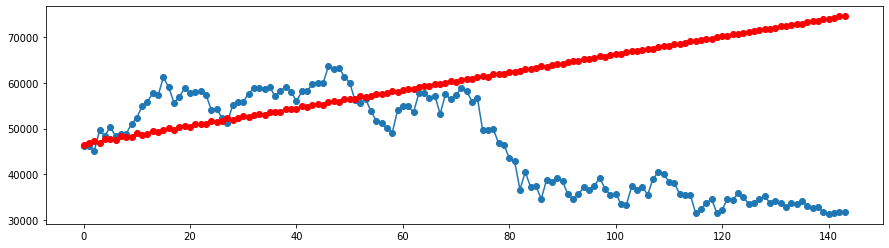

In [19]:
plt.figure(figsize=(15,4))
plt.plot(test,'o-')
plt.plot(predictions, 'o-', color='red');

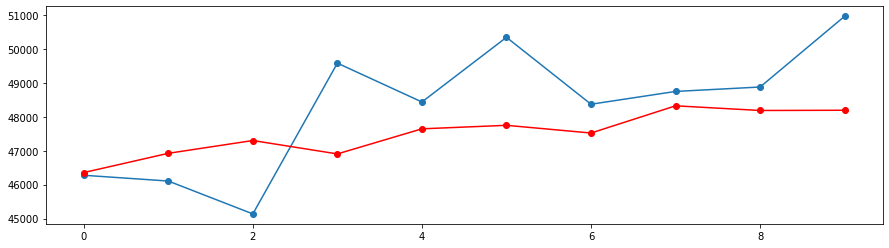

In [20]:
plt.figure(figsize=(15,4))
plt.plot(test[0:10],'o-')
plt.plot(predictions[0:10], 'o-', color='red');

In [21]:
print(mean_squared_error(test[:10],predictions[:10], squared=False))

1703.4256545365226


# 2. SARIMA & SARIMAX

In [80]:
p = range(2,5)
d = range(2,5)
q = range(2,5)
s = range(7,15)

In [81]:
pdqs = list(itertools.product(p, d, q, s))
len(pdqs)

216

In [82]:
pdqs = list(itertools.product(p, d, q, s))

results = []
for param in pdqs:
    model_arima = ARIMA(train,seasonal_order=param)
    model_arima_fit = model_arima.fit()
    results.append((param,model_arima_fit.aic))
    
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC')
resultados_df.head()

C:\Users\botic\anaconda3\envs\ironhack\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


LinAlgError: LU decomposition error.

In [23]:
model = ARIMA(train, seasonal_order=(3,2,4,10))

predictions = model.fit().predict(start=1290, end=1290+143)
print("MSE:",mean_squared_error(test,predictions, squared=False))

MSE: 40998.00301455805


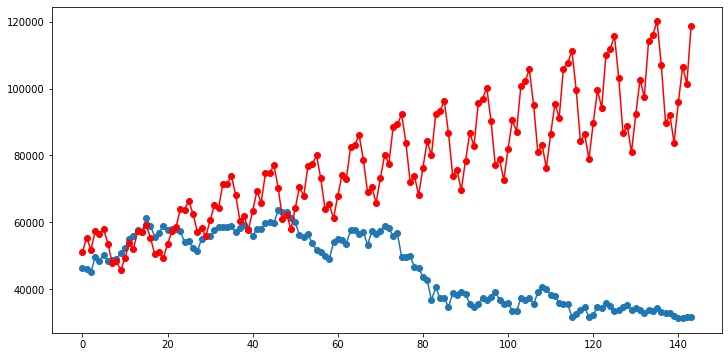

In [24]:
plt.figure(figsize=(12,6))
plt.plot(test,'o-')
plt.plot(predictions,'o-',color='red');

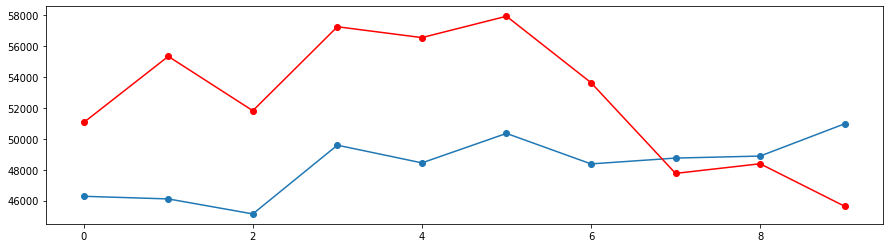

In [24]:
plt.figure(figsize=(15,4))
plt.plot(test[0:10],'o-')
plt.plot(predictions[0:10], 'o-', color='red');

In [25]:
print(mean_squared_error(test[:10],predictions[:10], squared=False))

6264.046435199926


### SARIMAX

- Primer modelo sarimax con una única variable exógena, valor de apertura
- Segundo modelo sarimax con dos variables exógenas, valor de apertura y valor más alto
- Tercer modelo sarimax con 3 variables exógenas, valor de apetura, y valor más alto y más bajo diario de BTC.

In [26]:
data2 = data.copy()
data2.set_index('date', inplace=True)

In [27]:
model = ARIMA(train, exog=data2[['open']][:1290],seasonal_order=(3,2,4,10))
print(model.fit().summary())

predictions = model.fit().predict(1290,1290+143, exog=data2[['open']][1290:])
print("mean_squared_error:", mean_squared_error(test, predictions, squared=False))

C:\Users\botic\anaconda3\envs\ironhack\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1290
Model:             ARIMA(3, 2, [1, 2, 3, 4], 10)   Log Likelihood              -10038.556
Date:                           Fri, 29 Dec 2023   AIC                          20095.112
Time:                                   18:32:48   BIC                          20141.433
Sample:                                        0   HQIC                         20112.511
                                          - 1290                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
open           0.9981      0.002    423.840      0.000       0.993       1.003
ar.S.L10      -1.4637      0.108    -13.614

C:\Users\botic\anaconda3\envs\ironhack\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


mean_squared_error: 2120.06381155598


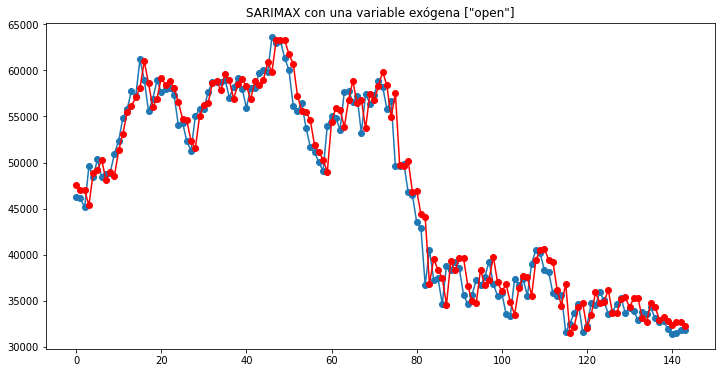

In [28]:
plt.figure(figsize=(12,6))
plt.plot(test,'o-')
plt.plot(predictions.values,'o-',color='red')
plt.title('SARIMAX con una variable exógena ["open"]');

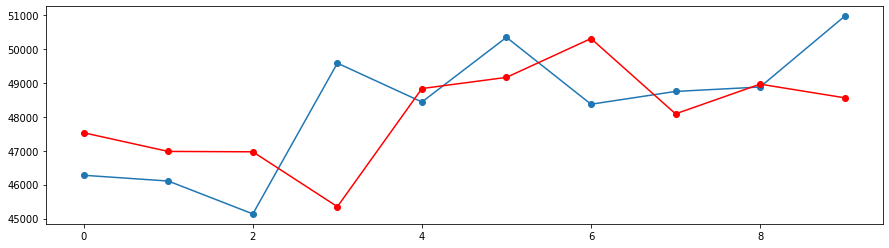

In [30]:
plt.figure(figsize=(15,4))
plt.plot(test[0:10],'o-')
plt.plot(predictions[0:10].values, 'o-', color='red');

In [32]:
print(mean_squared_error(test[:10],predictions[:10].values, squared=False))

1876.5538219555265


In [33]:
model = ARIMA(train, exog=data[['open', 'high']][:1290],seasonal_order=(3,2,4,10))
print(model.fit().summary())

predictions = model.fit().predict(1290,1290+143, exog=data[['open', 'high']][1290:])
print("mean_squared_error:", mean_squared_error(test, predictions, squared=False))

C:\Users\botic\anaconda3\envs\ironhack\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1290
Model:             ARIMA(3, 2, [1, 2, 3, 4], 10)   Log Likelihood               -9389.552
Date:                           Fri, 29 Dec 2023   AIC                          18799.104
Time:                                   18:36:15   BIC                          18850.572
Sample:                                        0   HQIC                         18818.437
                                          - 1290                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
open          -0.1538      0.013    -11.608      0.000      -0.180      -0.128
high           1.1000      0.013     87.014

C:\Users\botic\anaconda3\envs\ironhack\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


mean_squared_error: 1442.7743858917609


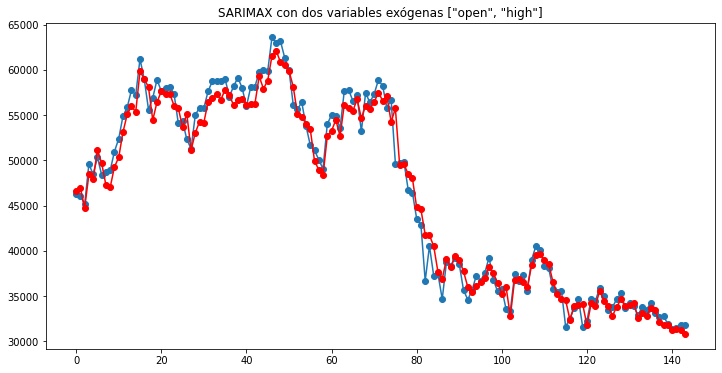

In [34]:
plt.figure(figsize=(12,6))
plt.plot(test,'o-')
plt.plot(predictions.values,'o-',color='red')
plt.title('SARIMAX con dos variables exógenas ["open", "high"]');

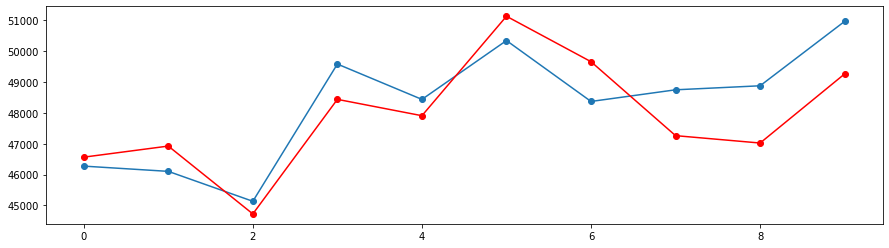

In [35]:
plt.figure(figsize=(15,4))
plt.plot(test[0:10],'o-')
plt.plot(predictions[0:10].values, 'o-', color='red');

In [36]:
print(mean_squared_error(test[:10],predictions[:10].values, squared=False))

1155.9337373964872


In [37]:
model = ARIMA(train, exog=data[['open', 'high', 'low']][:1290],seasonal_order=(3,2,4,10))
print(model.fit().summary())

predictions = model.fit().predict(1290,1290+143, exog=data[['open', 'high', 'low']][1290:])
print("mean_squared_error:", mean_squared_error(test, predictions, squared=False))

C:\Users\botic\anaconda3\envs\ironhack\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1290
Model:             ARIMA(3, 2, [1, 2, 3, 4], 10)   Log Likelihood               -8899.204
Date:                           Fri, 29 Dec 2023   AIC                          17820.408
Time:                                   18:37:45   BIC                          17877.022
Sample:                                        0   HQIC                         17841.674
                                          - 1290                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
open          -0.3646      0.011    -32.568      0.000      -0.386      -0.343
high           0.8417      0.011     78.800

C:\Users\botic\anaconda3\envs\ironhack\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


mean_squared_error: 916.401980785279


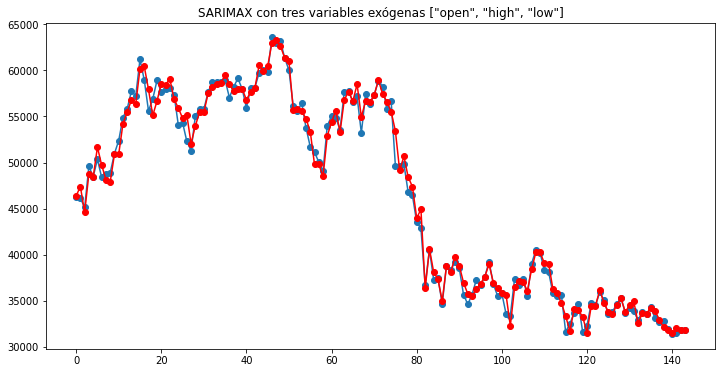

In [38]:
plt.figure(figsize=(12,6))
plt.plot(test,'o-')
plt.plot(predictions.values,'o-',color='red')
plt.title('SARIMAX con tres variables exógenas ["open", "high", "low"]');

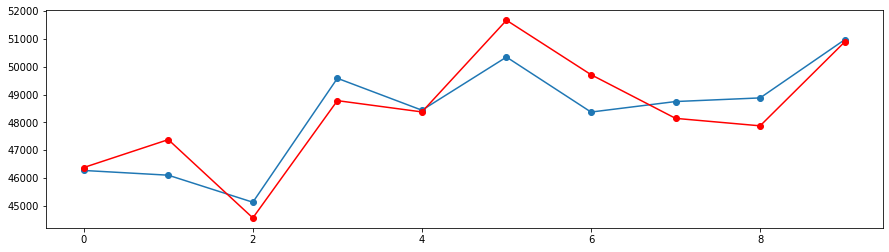

In [39]:
plt.figure(figsize=(15,4))
plt.plot(test[0:10],'o-')
plt.plot(predictions[0:10].values, 'o-', color='red');

In [40]:
print(mean_squared_error(test[:10],predictions[:10].values, squared=False))

868.1623774512987


In [75]:
print(mean_squared_error(test[:1],predictions[:1].values, squared=False))

105.18937039516459


# 3. LSTM

In [41]:
N = data.shape[0]
df2 = data[['close']].copy()
emb_size = 7
for i in range(1, emb_size+1):
    df2['lag' + str(i)] = df2['close'].shift(i)

df2.dropna(inplace=True)
df2.reset_index(drop=True, inplace=True)

values = df2.values
trainX, trainY = values[0:tp-emb_size,1:], values[0:tp-emb_size,0]
testX, testY = values[tp-emb_size:N-emb_size,1:], values[tp-emb_size:N-emb_size,0]

print("Train data length:", trainX.shape)
print("Train target length:", trainY.shape)
print("Test data length:", testX.shape)
print("Test target length:", testY.shape)

Train data length: (1283, 7)
Train target length: (1283,)
Test data length: (144, 7)
Test target length: (144,)


In [42]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [43]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (1283, 1, 7) ,  (1283,)
Test data shape: (144, 1, 7) ,  (144,)


In [44]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

def build_simple_rnn(num_units=128, embedding=7, num_dense=32, lr=0.001):
    """
    Builds and compiles a RNN model
    Arguments:
             num_units: Number of units of a RNN layer
             embedding: Embedding length
             num_dense: Number de neuronas in the dense layer
             lr: Learning rate
     Returns:
             A compiled Keras model
    """
    model = Sequential()
    model.add(LSTM(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=lr),
                 metrics=['mse'])
    
    return model

In [45]:
model = build_simple_rnn()

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 73,793
Trainable params: 73,793
Non-trainable params: 0
_________________________________________________________________


In [47]:
'''
Enseña mensaje si la epoch es multiplo de 50 y no ha acabado de entrenar.
Cada vez que termina una epoch, keras llama a on_epoch_end()
'''
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

In [48]:
batch_size=16
num_epochs = 50

In [49]:
model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0);

Epoch number 50 done


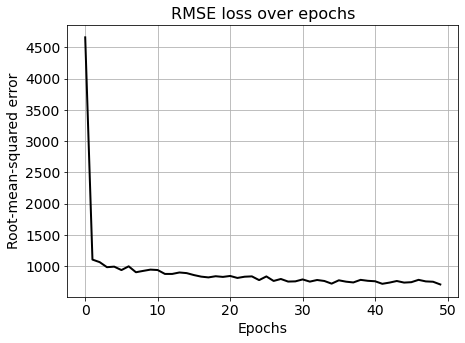

In [50]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [64]:
testPredict = model.predict(testX)

5/5 [==============================] - 0s 2ms/step


In [65]:
print(mean_squared_error(test,testPredict, squared=False))

2125.987083018249


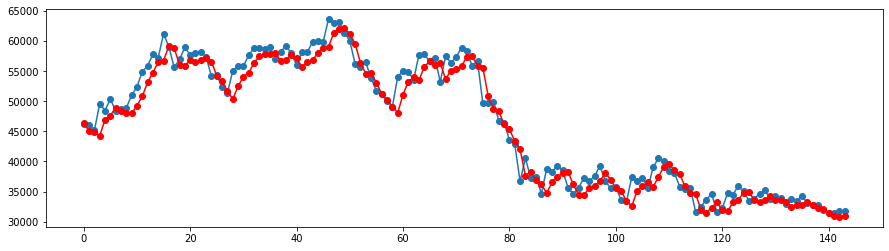

In [66]:
plt.figure(figsize=(15,4))
plt.plot(test,'o-')
plt.plot(testPredict, 'o-', color='red');

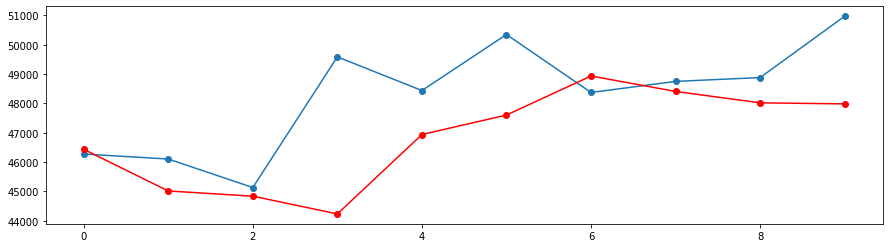

In [71]:
plt.figure(figsize=(15,4))
plt.plot(test[0:10],'o-')
plt.plot(testPredict[0:10], 'o-', color='red');

In [72]:
print(mean_squared_error(test[:10],testPredict[:10], squared=False))

2231.5171511499148


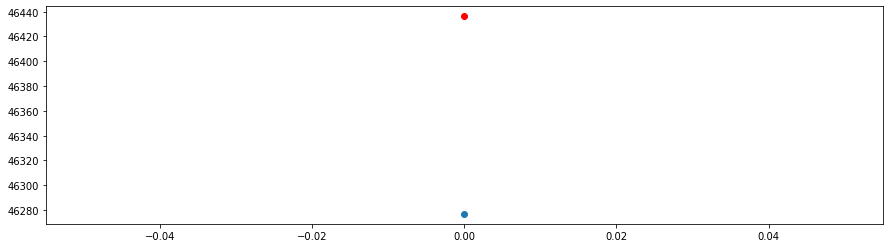

In [73]:
plt.figure(figsize=(15,4))
plt.plot(test[0:1],'o-')
plt.plot(testPredict[0:1], 'o-', color='red');

In [74]:
print(mean_squared_error(test[:1],testPredict[:1], squared=False))

159.46984374999738


In [54]:
np.corrcoef(test,testPredict.reshape(-1))

array([[1.        , 0.98190149],
       [0.98190149, 1.        ]])

In [55]:
def prediction(model, x_test):
    preds = x_test[0]
    preds_out = []
    
    for i in range(len(x_test)):
        if i ==0:
            pred = model.predict(np.expand_dims(preds, axis=0)).reshape(-1)
        else: 
            pred = model.predict(np.expand_dims([preds], axis=0)).reshape(-1)
        preds_out.append(pred)

        preds2 = np.array([preds.reshape(-1)[1:]])
        
        '''
        Concatenamos la nueva, es decir, el nuevo t-1
        '''
        preds = np.c_[preds2, np.array([pred])][0]
    return preds_out

In [56]:
testPredict = prediction(model,testX)

1/1 [==============================] - 0s 12ms/step


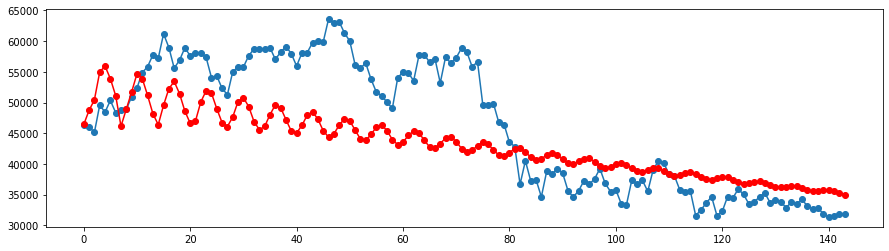

In [57]:
plt.figure(figsize=(15,4))
plt.plot(test,'o-')
plt.plot(testPredict, 'o-', color='red');

In [58]:
def plot_predictions_n_days(n_days:int):
    error = round(mean_squared_error(test[0:n_days], testPredict[0:n_days], squared=False),2)
    plt.figure(figsize=(15,4))
    plt.plot(test[0:n_days],'o-')
    plt.plot(testPredict[0:n_days], 'o-', color='red')
    plt.title(f'Predicciones a {n_days} días, MSE: {error}');
    

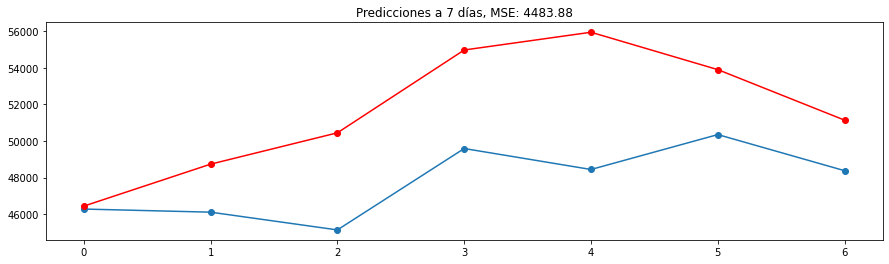

In [59]:
plot_predictions_n_days(7)

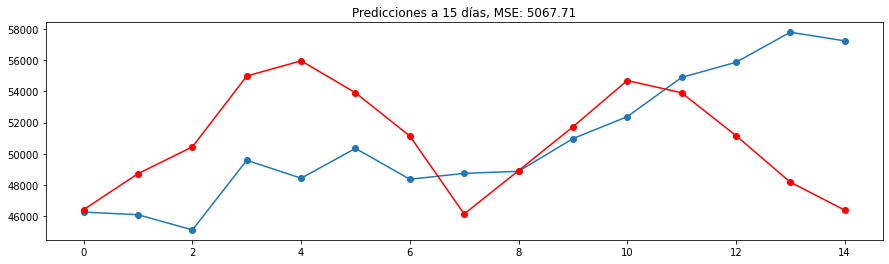

In [60]:
plot_predictions_n_days(15)

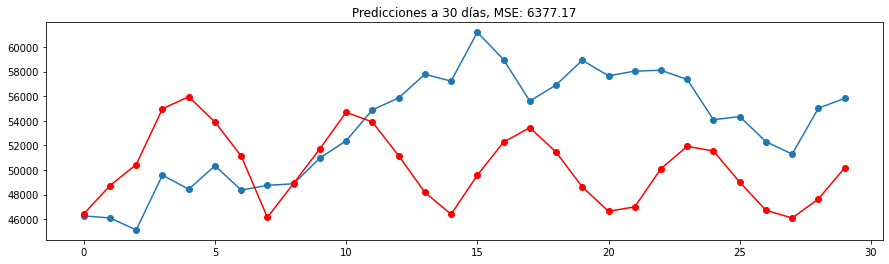

In [61]:
plot_predictions_n_days(30)